In [144]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import missingno as msno

# EDA on delays

In [145]:
df = pd.read_excel("../0_data/get_around_delay_analysis.xlsx", sheet_name='rentals_data')
df_doc = pd.read_excel("../0_data/get_around_delay_analysis.xlsx", sheet_name='Documentation')

df.head()


,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
0,505000,363965,mobile,canceled,NaN,NaN,NaN
1,507750,269550,mobile,ended,-81.0,NaN,NaN
2,508131,359049,connect,ended,70.0,NaN,NaN
3,508865,299063,connect,canceled,NaN,NaN,NaN
4,511440,313932,mobile,ended,NaN,NaN,NaN


In [146]:
df.describe(include = 'all')

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
count,21310.000000,21310.000000,21310,21310,16346.000000,1841.000000,1841.000000
unique,NaN,NaN,2,2,NaN,NaN,NaN
top,NaN,NaN,mobile,ended,NaN,NaN,NaN
freq,NaN,NaN,17003,18045,NaN,NaN,NaN
mean,549712.880338,350030.603426,NaN,NaN,59.701517,550127.411733,279.288430
std,13863.446964,58206.249765,NaN,NaN,1002.561635,13184.023111,254.594486
min,504806.000000,159250.000000,NaN,NaN,-22433.000000,505628.000000,0.000000
25%,540613.250000,317639.000000,NaN,NaN,-36.000000,540896.000000,60.000000
50%,550350.000000,368717.000000,NaN,NaN,9.000000,550567.000000,180.000000
75%,560468.500000,394928.000000,NaN,NaN,67.000000,560823.000000,540.000000


In [147]:
with pd.option_context('display.max_colwidth', None):
  display(df_doc)

,field name,Comment
0,rental_id,Unique identifier of the rental
1,car_id,Unique identifier of the car
2,checkin_type,"Flow used for both checkin and checkout. (ie. access and return the car)\nmobile = rental agreement signed on the owner's smartphone\nconnect = car equiped with the Connect technology , opened by the driver with his smartphone.\nNote: paper contracts were excluded from the data as we have no data on their delay at checkout and it's negligible use case"
3,state,canceled means that the rental did not happen (was canceled by the driver or the owner).
4,delay_at_checkout_in_minutes,Difference in minutes between the rental end time requested by the driver when booking the car and the actual time the driver completed the checkout. Negative values mean that the driver returned the car in advance.
5,previous_ended_rental_id,id of the previous ended rental of the car (NULL when no previous rental or delay with previous rental higher than 12 hours)
6,time_delta_with_previous_rental_in_minutes,"Difference in minutes between this rental planned start time and the previous rental planned end time (when lower than 12 hours, NULL if higher)"


<Axes: >

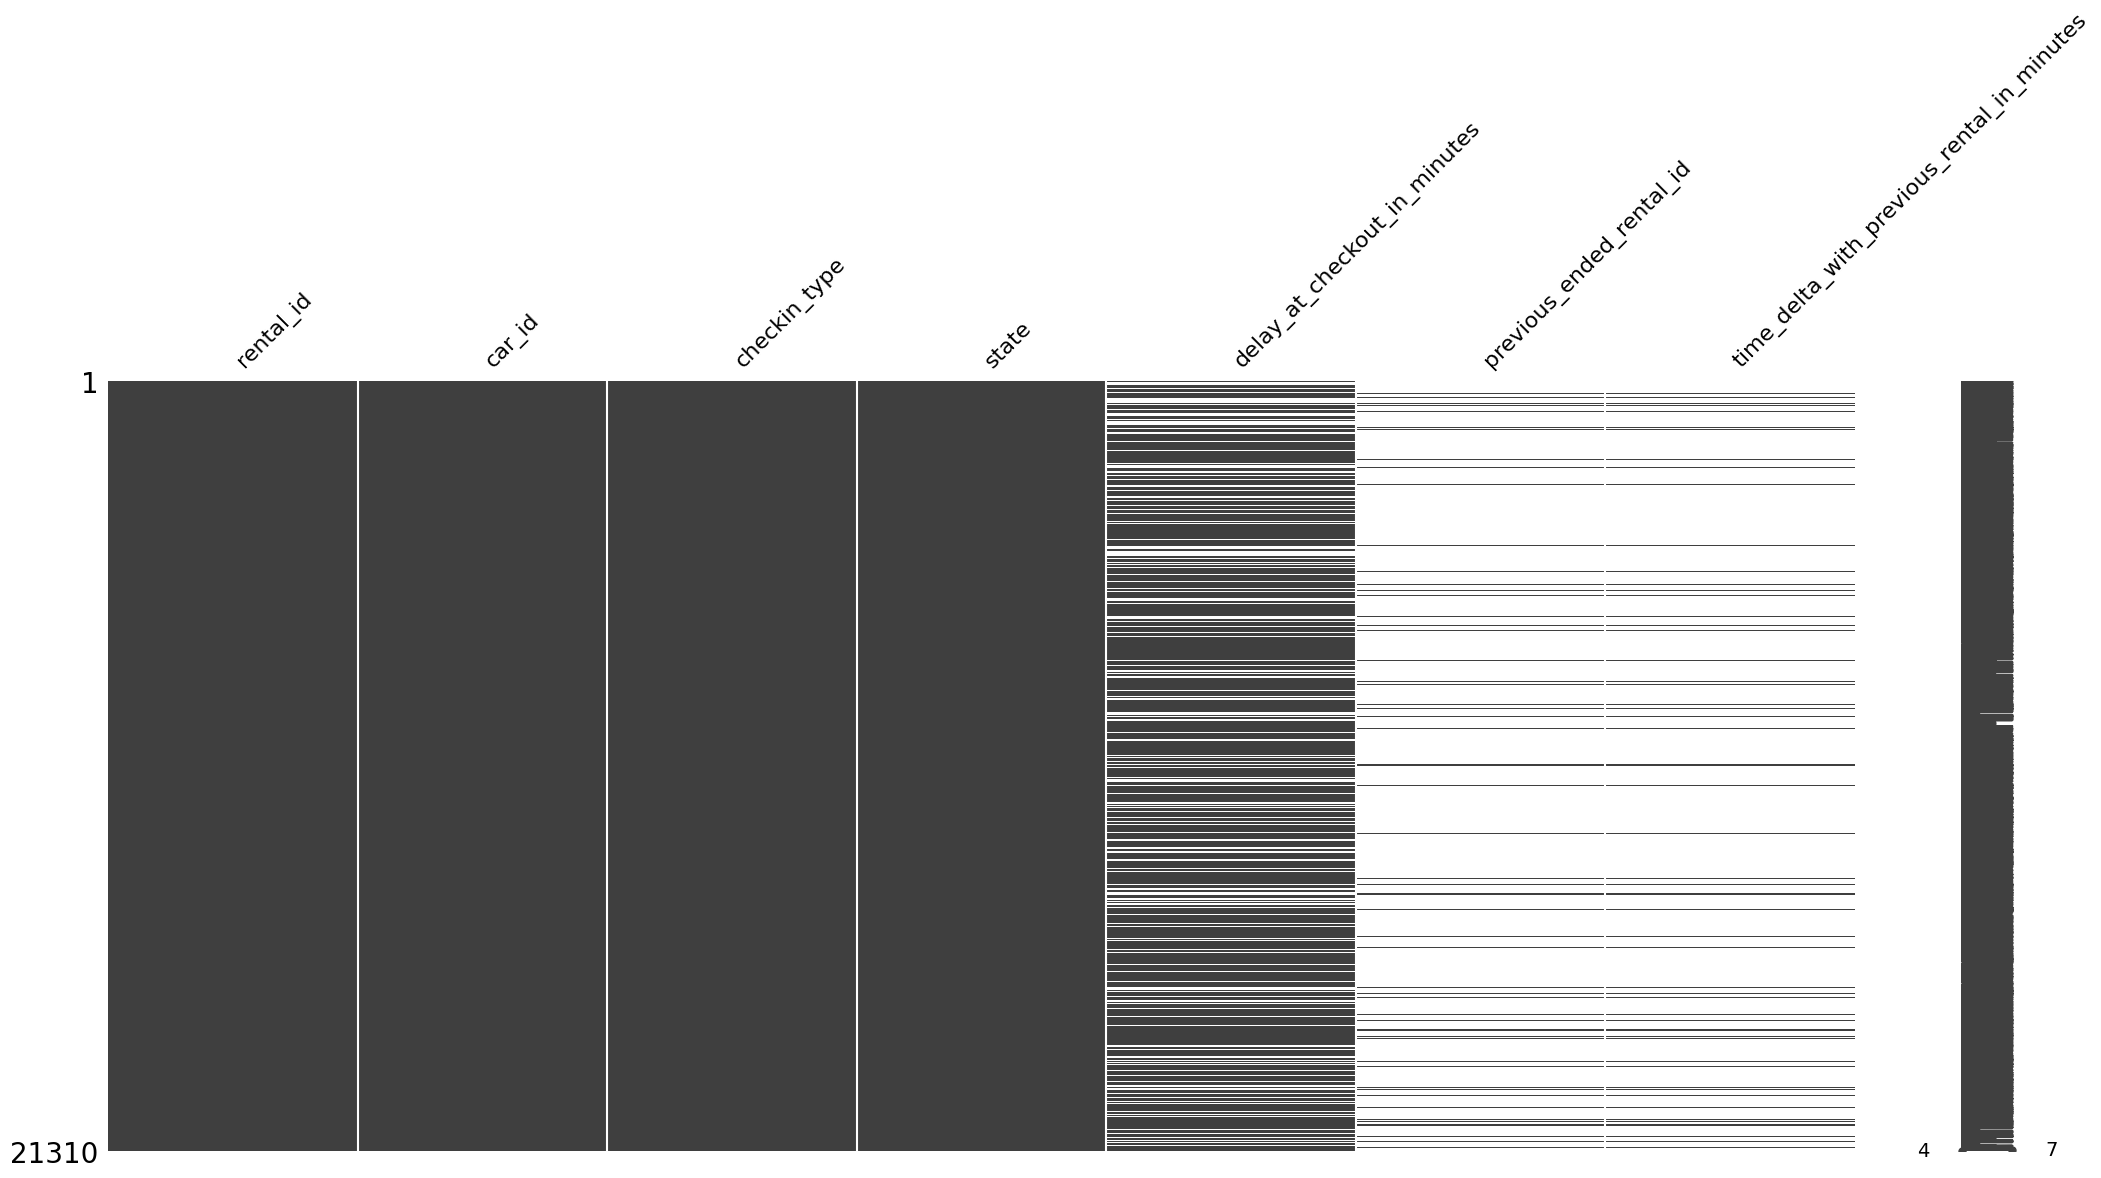

In [148]:
msno.matrix(df)

In [149]:
# What is the distribution of early, on-time and late check-outs ?
print(f"In total, there were {len(df)} car reservations.\n Amongst them, only {df['previous_ended_rental_id'].count()} have a previous rental ID information.")


In total, there were 21310 car reservations.
 Amongst them, only 1841 have a previous rental ID information.


In [150]:
df_checkin_type = df['checkin_type'].value_counts(normalize=True).reset_index()
fig = px.pie(df_checkin_type, values='proportion', names='checkin_type', title='Percentage of check-in types')
fig.show()

In [151]:
df['detailed_state'] = df['delay_at_checkout_in_minutes'].apply(lambda x : 'on_time' if x <= 0
                                                                else '1h_late_checkout' if 0<x<60
                                                                else '2h_late_checkout' if 60<x<120
                                                                else 'very_late_checkout' if x>120
                                                                else np.nan
                                                                )

# There are some rentals that are specified as ENDED but have a NaN value for delay in checkout in minutes. We presume those ended on time. 

df['detailed_state'] = df['detailed_state'].fillna(df['state'])
df['detailed_state'] = df['detailed_state'].replace('ended', 'unknown_checkout_time')
lst = ["on_time", "1h_late_checkout", '2h_late_checkout', 'very_late_checkout','canceled', 'unknown_checkout_time']
df_status = df['detailed_state'].value_counts(normalize=True).reset_index()
df_status['detailed_state'] = pd.Categorical(df_status['detailed_state'], lst, ordered=True)
df_status = df_status.sort_values('detailed_state')
df_status

,detailed_state,proportion
0,on_time,0.325763
1,1h_late_checkout,0.233505
4,2h_late_checkout,0.085312
3,very_late_checkout,0.119803
2,canceled,0.153168
5,unknown_checkout_time,0.082450


In [152]:
fig = go.Figure(
    data=[go.Pie(
        labels=df_status['detailed_state'],
        values=df_status['proportion'],
        sort=False, 
        hole = .5)
    ])
fig.update_layout(
        title = go.layout.Title(text = "Percentages of checkout statuses"))
fig.update_traces(marker=dict(colors=['#54A24B', 'RGB(253, 205, 172)', 'RGB(252, 141, 98)', 'RGB(217, 95, 2)',  '#DC3912','#7F7F7F']))
fig.show()

From this donut chart, we can conclude that :
- 33% of total rentals check-out on time or earlier
- 44 % of rentals are returned late 
- 15 % of rentals are cancelled
- 8 % "unknown" are data entries of rentals that did happen - but we don't have the data on their delay at check-out (NaN)

Let's now focus on the data where we have previous rental ID to see if there is a link between delayed return and current status of rental.

In [153]:
# Link each rentals with the previous rental to see if it has influence on cancellation or not
df1= df
df_merged = df.merge(df1, how='left', left_on='previous_ended_rental_id', right_on='rental_id', suffixes=['_current', '_previous'] )

#We're only going to consider the car rentals that have a previous rental ID
df_merged = df_merged.dropna(subset=['previous_ended_rental_id_current'])

print(f"This leaves us with a dataset of {df_merged.shape[0]} rentals.")

#Reorder the columns with previous rental information followed by current rental information.
df1 = df_merged[['rental_id_previous', 'checkin_type_previous', 'state_previous', 'detailed_state_previous', 'delay_at_checkout_in_minutes_previous', 'rental_id_current', 'checkin_type_current', 'state_current', 'time_delta_with_previous_rental_in_minutes_current', 'detailed_state_current' , 'delay_at_checkout_in_minutes_current' ]]
df1

This leaves us with a dataset of 1841 rentals.


,rental_id_previous,checkin_type_previous,state_previous,detailed_state_previous,delay_at_checkout_in_minutes_previous,rental_id_current,checkin_type_current,state_current,time_delta_with_previous_rental_in_minutes_current,detailed_state_current,delay_at_checkout_in_minutes_current
6,563782.0,connect,ended,very_late_checkout,136.0,511639,connect,ended,570.0,on_time,-15.0
19,545639.0,mobile,ended,very_late_checkout,140.0,519491,mobile,ended,420.0,1h_late_checkout,58.0
23,537298.0,mobile,ended,unknown_checkout_time,NaN,521156,mobile,ended,0.0,unknown_checkout_time,NaN
34,510607.0,mobile,ended,on_time,-113.0,525044,mobile,ended,60.0,unknown_checkout_time,NaN
40,557404.0,connect,ended,on_time,-352.0,528808,connect,ended,330.0,on_time,-76.0
...,...,...,...,...,...,...,...,...,...,...,...
21269,562174.0,connect,ended,2h_late_checkout,73.0,568049,connect,canceled,720.0,canceled,NaN
21272,566136.0,mobile,ended,1h_late_checkout,16.0,568241,mobile,canceled,570.0,canceled,NaN
21275,567121.0,mobile,ended,on_time,-275.0,568523,mobile,ended,240.0,1h_late_checkout,12.0
21286,545045.0,mobile,ended,1h_late_checkout,22.0,569717,mobile,ended,90.0,very_late_checkout,230.0


In [154]:
df1.loc[:,'checkin_delay_in_minutes'] = df1['delay_at_checkout_in_minutes_previous'] - df1['time_delta_with_previous_rental_in_minutes_current']
df1

,rental_id_previous,checkin_type_previous,state_previous,detailed_state_previous,delay_at_checkout_in_minutes_previous,rental_id_current,checkin_type_current,state_current,time_delta_with_previous_rental_in_minutes_current,detailed_state_current,delay_at_checkout_in_minutes_current,checkin_delay_in_minutes
6,563782.0,connect,ended,very_late_checkout,136.0,511639,connect,ended,570.0,on_time,-15.0,-434.0
19,545639.0,mobile,ended,very_late_checkout,140.0,519491,mobile,ended,420.0,1h_late_checkout,58.0,-280.0
23,537298.0,mobile,ended,unknown_checkout_time,NaN,521156,mobile,ended,0.0,unknown_checkout_time,NaN,NaN
34,510607.0,mobile,ended,on_time,-113.0,525044,mobile,ended,60.0,unknown_checkout_time,NaN,-173.0
40,557404.0,connect,ended,on_time,-352.0,528808,connect,ended,330.0,on_time,-76.0,-682.0
...,...,...,...,...,...,...,...,...,...,...,...,...
21269,562174.0,connect,ended,2h_late_checkout,73.0,568049,connect,canceled,720.0,canceled,NaN,-647.0
21272,566136.0,mobile,ended,1h_late_checkout,16.0,568241,mobile,canceled,570.0,canceled,NaN,-554.0
21275,567121.0,mobile,ended,on_time,-275.0,568523,mobile,ended,240.0,1h_late_checkout,12.0,-515.0
21286,545045.0,mobile,ended,1h_late_checkout,22.0,569717,mobile,ended,90.0,very_late_checkout,230.0,-68.0


In [155]:
m1 = (df1['checkin_delay_in_minutes'] > 0) & (df1['state_current'] == 'canceled')
m2 = (df1['checkin_delay_in_minutes'] > 0) & (df1['state_current'] == 'ended')
m3 = (df1['checkin_delay_in_minutes'] < 0) & (df1['state_current'] == 'ended')

df1.loc[:,'impact'] = np.select([m1, m2, m3], ['Cancellation due to late checkout of previous rental', 'Late checkin', 'No impact'], 
                           default='No data')
df1

,rental_id_previous,checkin_type_previous,state_previous,detailed_state_previous,delay_at_checkout_in_minutes_previous,rental_id_current,checkin_type_current,state_current,time_delta_with_previous_rental_in_minutes_current,detailed_state_current,delay_at_checkout_in_minutes_current,checkin_delay_in_minutes,impact
6,563782.0,connect,ended,very_late_checkout,136.0,511639,connect,ended,570.0,on_time,-15.0,-434.0,No impact
19,545639.0,mobile,ended,very_late_checkout,140.0,519491,mobile,ended,420.0,1h_late_checkout,58.0,-280.0,No impact
23,537298.0,mobile,ended,unknown_checkout_time,NaN,521156,mobile,ended,0.0,unknown_checkout_time,NaN,NaN,No data
34,510607.0,mobile,ended,on_time,-113.0,525044,mobile,ended,60.0,unknown_checkout_time,NaN,-173.0,No impact
40,557404.0,connect,ended,on_time,-352.0,528808,connect,ended,330.0,on_time,-76.0,-682.0,No impact
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21269,562174.0,connect,ended,2h_late_checkout,73.0,568049,connect,canceled,720.0,canceled,NaN,-647.0,No data
21272,566136.0,mobile,ended,1h_late_checkout,16.0,568241,mobile,canceled,570.0,canceled,NaN,-554.0,No data
21275,567121.0,mobile,ended,on_time,-275.0,568523,mobile,ended,240.0,1h_late_checkout,12.0,-515.0,No impact
21286,545045.0,mobile,ended,1h_late_checkout,22.0,569717,mobile,ended,90.0,very_late_checkout,230.0,-68.0,No impact


In [156]:
df_impact = df1['impact'].value_counts(normalize=True).reset_index()
color_mapping = {'No impact' : 'green', 'No data' : 'grey',
       'Cancellation due to late checkout of previous rental' : 'red',
       'Late checkin' : '#FF9900'}
fig = px.pie(df_impact, values='proportion', names='impact', color = 'impact', color_discrete_map=color_mapping, title='Impact of previous rental checkout delay on current rental checkin')
fig.show()

In [163]:
df1

,rental_id_previous,checkin_type_previous,state_previous,detailed_state_previous,delay_at_checkout_in_minutes_previous,rental_id_current,checkin_type_current,state_current,time_delta_with_previous_rental_in_minutes_current,detailed_state_current,delay_at_checkout_in_minutes_current,checkin_delay_in_minutes,impact
34,510607.0,mobile,ended,on_time,-113.0,525044,mobile,ended,60.0,unknown_checkout_time,NaN,-173.0,No impact
40,557404.0,connect,ended,on_time,-352.0,528808,connect,ended,330.0,on_time,-76.0,-682.0,No impact
107,539005.0,mobile,ended,on_time,-29.0,537576,mobile,ended,0.0,1h_late_checkout,18.0,-29.0,No impact
195,552619.0,connect,ended,on_time,-38.0,543328,connect,ended,240.0,on_time,-9.0,-278.0,No impact
206,536315.0,mobile,ended,on_time,-191.0,543808,mobile,ended,60.0,2h_late_checkout,75.0,-251.0,No impact
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21047,555245.0,mobile,ended,unknown_checkout_time,NaN,562282,mobile,ended,570.0,very_late_checkout,126.0,NaN,No data
21172,568465.0,connect,ended,unknown_checkout_time,NaN,566228,connect,canceled,60.0,canceled,NaN,NaN,No data
21197,552222.0,mobile,ended,unknown_checkout_time,NaN,567305,mobile,canceled,0.0,canceled,NaN,NaN,No data
21228,568778.0,connect,ended,unknown_checkout_time,NaN,569688,connect,ended,690.0,2h_late_checkout,61.0,NaN,No data


In [165]:
df1['detailed_state_previous'] = pd.Categorical(df1['detailed_state_previous'], lst, ordered=True)
df1['impact'] = pd.Categorical(df1['impact'], ['No impact', 'Late checkin', 'Cancellation due to late checkout of previous rental', 'No data'], ordered=True)
df1 = df1.sort_values(['detailed_state_previous', 'impact'])
color_mapping = {'No impact' : 'green', 'No data' : 'grey',
       'Cancellation due to late checkout of previous rental' : 'red',
       'Late checkin' : '#FF9900'}
fig = px.histogram(df1, x="detailed_state_previous", 
             color='impact', color_discrete_map=color_mapping, 
             category_orders=dict(previous_rental_state=df1['detailed_state_previous'].unique()),
             barnorm = 'percent', text_auto=True, 
             facet_row='checkin_type_current',
             title='Impact of previous rental car delay on current rental status')
fig.show()


It is obvious that when the previous rental car is returned more than 2 hours after due date, the rate of cancellation drastically increases from 2% to 14%.
It is therefore interesting to install a threshold of duration between two consecutive rentals in order to minimize these cancellations. 

In [166]:
timedelta_avg = df1['time_delta_with_previous_rental_in_minutes_current'].mean()
fig = px.histogram(df1, x = "time_delta_with_previous_rental_in_minutes_current", color = 'impact', color_discrete_map=color_mapping, )
fig.add_vline(x=timedelta_avg, line_color = 'grey', line_dash = 'dash', annotation_text ='Average time difference : 4h30min')
fig.update_layout(title="Distribution of Time Difference planned between Consecutive Rentals",xaxis_title="Time difference (minutes)",yaxis_title="Count",showlegend=True)
fig.show()

In [167]:
timedelta_avg = df1['time_delta_with_previous_rental_in_minutes_current'].mean()
fig = px.histogram(df1, x = "time_delta_with_previous_rental_in_minutes_current", 
                   color = 'impact', color_discrete_map=color_mapping,
                   barnorm='percent', text_auto=True ,
                   nbins=30)
fig.update_layout(title="Percentage of various impacts according to time difference between two consecutive rentals",xaxis_title="Time difference (minutes)",yaxis_title="Percentage",showlegend=True)
fig.show()

- There is a significantly higher rate of cancellation when the time difference is between two rentals is shorter than 40 min with 5.3%. In this case, 35% of next rentals have late checkin.
- As time difference increases, up until 5 hours time difference, the cancellation rate diminishes by half. 

We can consider that above 90% of no impact in current car is sufficient for business, which would mean a threshold of 90-110 min.
The minimum time difference of 90 min between two car rentals would be enough to ensure >90% of car rentals happen as planned.
The very confortable time difference of 240 min (4 hours) ensures that abode 98% of car rentals happen without impact. 

Below is to see if there is a different scope for connect cars or for mobile cars.

In [168]:
timedelta_avg = df1['time_delta_with_previous_rental_in_minutes_current'].mean()
fig = px.histogram(df1, x = "time_delta_with_previous_rental_in_minutes_current", 
                   facet_row='checkin_type_current',
                   color = 'impact', color_discrete_map=color_mapping,
                   barnorm='percent', text_auto=True ,
                   nbins=30)
fig.update_layout(title="Percentage of various impacts according to time difference between two consecutive rentals",xaxis_title="Time difference (minutes)",yaxis_title="Percentage",showlegend=True)
fig.show()

above : connect cars
below : mobile cars
it is obvious that mobile checkin car are more impacted than connect cars : there are way more delayed checkin (double).
[réajuster le graphe pour qu'on voit bien toutes les valeurs]

# EDA on pricing


In [169]:
df2 = pd.read_csv("../0_data/get_around_pricing_project.csv")

df2.head()

,Unnamed: 0,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,1,Citroën,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,264
2,2,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
3,3,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
4,4,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Unnamed: 0                 4843 non-null   int64 
 1   model_key                  4843 non-null   object
 2   mileage                    4843 non-null   int64 
 3   engine_power               4843 non-null   int64 
 4   fuel                       4843 non-null   object
 5   paint_color                4843 non-null   object
 6   car_type                   4843 non-null   object
 7   private_parking_available  4843 non-null   bool  
 8   has_gps                    4843 non-null   bool  
 9   has_air_conditioning       4843 non-null   bool  
 10  automatic_car              4843 non-null   bool  
 11  has_getaround_connect      4843 non-null   bool  
 12  has_speed_regulator        4843 non-null   bool  
 13  winter_tires               4843 non-null   bool  
 14  rental_p

In this dataset, we have 4843 entries of cars. 

In [ ]:
df2.describe(include='all')

,Unnamed: 0,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
count,4843.000000,4843,4.843000e+03,4843.00000,4843,4843,4843,4843,4843,4843,4843,4843,4843,4843,4843.000000
unique,NaN,28,NaN,NaN,4,10,8,2,2,2,2,2,2,2,NaN
top,NaN,Citroën,NaN,NaN,diesel,black,estate,True,True,False,False,False,False,True,NaN
freq,NaN,969,NaN,NaN,4641,1633,1606,2662,3839,3865,3881,2613,3674,4514,NaN
mean,2421.000000,NaN,1.409628e+05,128.98823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121.214536
std,1398.198007,NaN,6.019674e+04,38.99336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.568268
min,0.000000,NaN,-6.400000e+01,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.000000
25%,1210.500000,NaN,1.029135e+05,100.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.000000
50%,2421.000000,NaN,1.410800e+05,120.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119.000000
75%,3631.500000,NaN,1.751955e+05,135.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.000000


In [ ]:
fig = px.histogram(df2, x='model_key')
fig.show()

In [ ]:
df2['rental_price_per_day'].mean()

121.21453644435267

In [ ]:
fig = ff.create_distplot([df2['rental_price_per_day']], group_labels=['distplot'])
fig.add_vline(x=df2['rental_price_per_day'].mean(), line_color = 'red', line_dash = 'dash', annotation_text ='Average rental price : 121 E/day')
fig.update_layout(title="Distribution of Rental Price per Day",xaxis_title="Rental price per day",yaxis_title="Density",showlegend=True)
fig.show()

In [ ]:
df2.columns

Index(['Unnamed: 0', 'model_key', 'mileage', 'engine_power', 'fuel',
       'paint_color', 'car_type', 'private_parking_available', 'has_gps',
       'has_air_conditioning', 'automatic_car', 'has_getaround_connect',
       'has_speed_regulator', 'winter_tires', 'rental_price_per_day'],
      dtype='object')

faire un graphe avec 4 camemberts : pour le premier, mettre tous ceux en dessous de mistubishi en 'other'
pour les couleurs mettre les vraies couleurs de voitures 
a cote de chaque camembert, indiquer le prix moyen pour voir sil y a des differences

In [ ]:
condition = ['model_key', 'fuel', 'paint_color', 'car_type']
for i, cond in enumerate(condition) :
    d = round(df2.groupby(cond)['rental_price_per_day'].mean().reset_index().merge(df2[cond].value_counts(normalize=True).reset_index(), on=cond), 2)
    fig = px.pie(d, hover_data='rental_price_per_day', values='proportion', names=cond, title='Percentages depending on ' + cond)
    fig.show()

In [ ]:
condition = ['private_parking_available', 'has_gps',
       'has_air_conditioning', 'automatic_car', 'has_getaround_connect',
       'has_speed_regulator', 'winter_tires']

for i, cond in enumerate(condition) :
    fig = px.histogram(df2, x = "rental_price_per_day", 
                    color = cond, marginal = 'box')
    fig.update_layout(title="Distribution of rental price per day according to " + cond,xaxis_title="rental price per day",yaxis_title="Count",showlegend=True)
    fig.show()

### Conlusion partielle :
From EDA, we can determine a threshold of 90 minutes - 1 hour and a half between two rentals so that late check in doesn't affect us too much (enables >90% no impacts).
The equivalent for connect or mobile rentals.
Let's see the influence of threshold on revenue. 

In [170]:
df

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes,detailed_state
0,505000,363965,mobile,canceled,NaN,NaN,NaN,canceled
1,507750,269550,mobile,ended,-81.0,NaN,NaN,on_time
2,508131,359049,connect,ended,70.0,NaN,NaN,2h_late_checkout
3,508865,299063,connect,canceled,NaN,NaN,NaN,canceled
4,511440,313932,mobile,ended,NaN,NaN,NaN,unknown_checkout_time
...,...,...,...,...,...,...,...,...
21305,573446,380069,mobile,ended,NaN,573429.0,300.0,unknown_checkout_time
21306,573790,341965,mobile,ended,-337.0,NaN,NaN,on_time
21307,573791,364890,mobile,ended,144.0,NaN,NaN,very_late_checkout
21308,574852,362531,connect,ended,-76.0,NaN,NaN,on_time


In [180]:
df3 = df.copy()


21310

In [213]:
df1

,rental_id_previous,checkin_type_previous,state_previous,detailed_state_previous,delay_at_checkout_in_minutes_previous,rental_id_current,checkin_type_current,state_current,time_delta_with_previous_rental_in_minutes_current,detailed_state_current,delay_at_checkout_in_minutes_current,checkin_delay_in_minutes,impact
34,510607.0,mobile,ended,on_time,-113.0,525044,mobile,ended,60.0,unknown_checkout_time,NaN,-173.0,No impact
40,557404.0,connect,ended,on_time,-352.0,528808,connect,ended,330.0,on_time,-76.0,-682.0,No impact
107,539005.0,mobile,ended,on_time,-29.0,537576,mobile,ended,0.0,1h_late_checkout,18.0,-29.0,No impact
195,552619.0,connect,ended,on_time,-38.0,543328,connect,ended,240.0,on_time,-9.0,-278.0,No impact
206,536315.0,mobile,ended,on_time,-191.0,543808,mobile,ended,60.0,2h_late_checkout,75.0,-251.0,No impact
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21047,555245.0,mobile,ended,unknown_checkout_time,NaN,562282,mobile,ended,570.0,very_late_checkout,126.0,NaN,No data
21172,568465.0,connect,ended,unknown_checkout_time,NaN,566228,connect,canceled,60.0,canceled,NaN,NaN,No data
21197,552222.0,mobile,ended,unknown_checkout_time,NaN,567305,mobile,canceled,0.0,canceled,NaN,NaN,No data
21228,568778.0,connect,ended,unknown_checkout_time,NaN,569688,connect,ended,690.0,2h_late_checkout,61.0,NaN,No data


In [200]:
# Toute cette étude ne peut être réalisée que sur les 1841 données pour lesquelles nous avons des données sur les rentals précédentes.
threshold = [0, 30, 45, 60, 90, 120, 180, 240, 300, 400, 600, 800]
# on visualise le nombre de réservations qui n'aauraient pas eu lieu si on avait instauré une threshold de X minutes
for t in threshold :
    df3[df3['time_delta_with_previous_rental_[df3[df3['time_delta_with_previous_rental_in_minutes' ] < t].shape[0] for t in threshold]in_minutes' ] < t].shape[0]
nb = 
nb    

[0, 279, 401, 401, 584, 666, 870, 1001, 1106, 1226, 1449, 1841]

In [214]:
# Toute cette étude ne peut être réalisée que sur les 1841 données pour lesquelles nous avons des données sur les rentals précédentes.
threshold = [0, 30, 45, 60, 90, 120, 180, 240, 300, 400, 600, 800]
# on visualise le nombre de réservations qui n'aauraient pas eu lieu si on avait instauré une threshold de X minutes
total_data = df1[df1['time_delta_with_previous_rental_in_minutes_current' ] < 800].shape[0]
df_t = pd.DataFrame()
df_t['t'] = threshold
df_t['nb_rentals_within_t'] = [df1[df1['time_delta_with_previous_rental_in_minutes_current' ] < t].shape[0] for t in threshold]
df_t['Percent_rental_less'] = round(df_t['nb_rentals_within_t'] / total_data * 100, 2)
df_t

,t,nb_rentals_within_t,Percent_rental_less
0,0,0,0.00
1,30,279,15.15
2,45,401,21.78
3,60,401,21.78
4,90,584,31.72
5,120,666,36.18
6,180,870,47.26
7,240,1001,54.37
8,300,1106,60.08
9,400,1226,66.59


In [215]:
df1

,rental_id_previous,checkin_type_previous,state_previous,detailed_state_previous,delay_at_checkout_in_minutes_previous,rental_id_current,checkin_type_current,state_current,time_delta_with_previous_rental_in_minutes_current,detailed_state_current,delay_at_checkout_in_minutes_current,checkin_delay_in_minutes,impact
34,510607.0,mobile,ended,on_time,-113.0,525044,mobile,ended,60.0,unknown_checkout_time,NaN,-173.0,No impact
40,557404.0,connect,ended,on_time,-352.0,528808,connect,ended,330.0,on_time,-76.0,-682.0,No impact
107,539005.0,mobile,ended,on_time,-29.0,537576,mobile,ended,0.0,1h_late_checkout,18.0,-29.0,No impact
195,552619.0,connect,ended,on_time,-38.0,543328,connect,ended,240.0,on_time,-9.0,-278.0,No impact
206,536315.0,mobile,ended,on_time,-191.0,543808,mobile,ended,60.0,2h_late_checkout,75.0,-251.0,No impact
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21047,555245.0,mobile,ended,unknown_checkout_time,NaN,562282,mobile,ended,570.0,very_late_checkout,126.0,NaN,No data
21172,568465.0,connect,ended,unknown_checkout_time,NaN,566228,connect,canceled,60.0,canceled,NaN,NaN,No data
21197,552222.0,mobile,ended,unknown_checkout_time,NaN,567305,mobile,canceled,0.0,canceled,NaN,NaN,No data
21228,568778.0,connect,ended,unknown_checkout_time,NaN,569688,connect,ended,690.0,2h_late_checkout,61.0,NaN,No data


In [227]:
def apply_threshold(dataframe, threshold, scope):
    if scope == 'All':
        rows_to_drop_df = dataframe[dataframe['time_delta_with_previous_rental_in_minutes_current'] < threshold]
    elif scope == "'Connect'":
        rows_to_drop_df = dataframe[(dataframe['time_delta_with_previous_rental_in_minutes_current'] < threshold) & (dataframe['checkin_type_current'] == 'connect')]
    nb_ended_rentals_dropped = len(dataframe[(dataframe['detailed_state_current'] == 'on_time') 
                                             | (dataframe['detailed_state_current'] == '1h_late_checkout') 
                                             | (dataframe['detailed_state_current'] == '2h_late_checkout')
                                             | (dataframe['detailed_state_current'] == 'very_late_checkout')](rows_to_drop_df))
    nb_late_checkins_cancelations_dropped = len(dataframe[(dataframe['impact'] == 'Cancellation due to late checkout of previous rental')](rows_to_drop_df))
    output = (
        dataframe.drop(rows_to_drop_df.index),
        nb_ended_rentals_dropped,
        nb_late_checkins_cancelations_dropped  
    )
    return output




In [230]:
apply_threshold(df1, 45, scope = 'Connect')

UnboundLocalError: cannot access local variable 'rows_to_drop_df' where it is not associated with a value